In [2]:
## importing
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

In [ ]:
## resize image
filelist = os.listdir('img_align_celeba')
for i, file in enumerate(filelist):
    im = Image.open('img_align_celeba/'+file)
    new_im = im.resize(size)
    new_im.save('resized_img/file_{}.jpg'.format(i))

In [ ]:
## creating tfrecord
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = 'celeba.tfrecords'
filelist = os.listdir('resized_img')
writer = tf.python_io.TFRecordWriter(tfrecords_filename)

for img_path in filelist:

    img = (np.array(Image.open('resized_img/' + img_path), np.float32) - 127.5)/127.5
    img_bytes = img.tostring()
    shape = np.shape(img)
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(shape[0]),
        'width': _int64_feature(shape[1]),
        'image_raw': _bytes_feature(img_bytes)}))
    
    writer.write(example.SerializeToString())
    
writer.close()

In [3]:
## setting parameters
path = 'celeba.tfrecords'
batch_size = 128
learning_rate = 0.0002
epoch = 5

## setting Variables
g_w1 = tf.Variable(tf.truncated_normal([4, 4, 1024, 100], stddev=0.02), name="g_w1")
g_w2 = tf.Variable(tf.truncated_normal([4, 4, 512, 1024], stddev=0.02), name='g_w2')
g_w3 = tf.Variable(tf.truncated_normal([4, 4, 256, 512], stddev=0.02), name='g_w3')
g_w4 = tf.Variable(tf.truncated_normal([4, 4, 128, 256], stddev=0.02), name='g_w4')
g_w5 = tf.Variable(tf.truncated_normal([4, 4, 3, 128], stddev=0.02), name='g_w5')

d_w1 = tf.Variable(tf.truncated_normal([4, 4, 3, 128], stddev=0.02), name='d_w1')
d_w2 = tf.Variable(tf.truncated_normal([4, 4, 128, 256], stddev=0.02), name='d_w2')
d_w3 = tf.Variable(tf.truncated_normal([4, 4, 256, 512], stddev=0.02), name='d_w3')
d_w4 = tf.Variable(tf.truncated_normal([4, 4, 512, 1024], stddev=0.02), name='d_w4')
d_w5 = tf.Variable(tf.truncated_normal([4, 4, 1024, 1], stddev=0.02), name='d_w5')


## generator
def generator(z):
    z_reshape = tf.reshape(z, [-1, 1, 1, 100])
    conv1 = tf.nn.conv2d_transpose(z_reshape, g_w1, output_shape=[batch_size, 4, 4, 1024], strides=[1, 4, 4, 1])
    conv1_bn = tf.contrib.layers.batch_norm(conv1, decay=0.9, updates_collections=None)
    conv1_a = tf.nn.relu(conv1_bn)

    conv2 = tf.nn.conv2d_transpose(conv1_a, g_w2, output_shape=[batch_size, 8, 8, 512], strides=[1, 2, 2, 1])
    conv2_bn = tf.contrib.layers.batch_norm(conv2, decay=0.9, updates_collections=None)
    conv2_a = tf.nn.relu(conv2_bn)

    conv3 = tf.nn.conv2d_transpose(conv2_a, g_w3, output_shape=[batch_size, 16, 16, 256], strides=[1, 2, 2, 1])
    conv3_bn = tf.contrib.layers.batch_norm(conv3, decay=0.9, updates_collections=None)
    conv3_a = tf.nn.relu(conv3_bn)

    conv4 = tf.nn.conv2d_transpose(conv3_a, g_w4, output_shape=[batch_size, 32, 32, 128], strides=[1, 2, 2, 1])
    conv4_bn = tf.contrib.layers.batch_norm(conv4, decay=0.9, updates_collections=None)
    conv4_a = tf.nn.relu(conv4_bn)

    conv5 = tf.nn.conv2d_transpose(conv4_a, g_w5, output_shape=[batch_size, 64, 64, 3], strides=[1, 2, 2, 1])

    x = tf.nn.tanh(conv5)
    return x

## discrrminator
def discriminator(x):
  
    conv1 = tf.nn.conv2d(x, d_w1, strides=[1, 2, 2, 1], padding='SAME')
    conv1_a = tf.nn.leaky_relu(conv1, alpha=0.2)
  
    conv2 = tf.nn.conv2d(conv1_a, d_w2, strides=[1, 2, 2, 1], padding='SAME')
    conv2_bn = tf.contrib.layers.batch_norm(conv2, decay=0.9, updates_collections=None)
    conv2_a = tf.nn.leaky_relu(conv2_bn, alpha=0.2)
  
    conv3 = tf.nn.conv2d(conv2_a, d_w3, strides=[1, 2, 2, 1], padding='SAME')
    conv3_bn = tf.contrib.layers.batch_norm(conv3, decay=0.9, updates_collections=None)
    conv3_a = tf.nn.leaky_relu(conv3_bn, alpha=0.2)
  
    conv4 = tf.nn.conv2d(conv3_a, d_w4, strides=[1, 2, 2, 1], padding='SAME')
    conv4_bn = tf.contrib.layers.batch_norm(conv4, decay=0.9, updates_collections=None)
    conv4_a = tf.nn.leaky_relu(conv4_bn, alpha=0.2)
  
    conv5 = tf.nn.conv2d(conv4_a, d_w5, strides=[1, 2, 2, 1], padding='SAME')
    conv5_a = tf.nn.leaky_relu(conv5, alpha=0.2)
  
    conv5_a_reshape = tf.reshape(conv5_a, [-1, 1])
    y = tf.nn.sigmoid(conv5_a_reshape)

    return y

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
## setting graph
Z = tf.placeholder(tf.float32, [batch_size, 100])
X = tf.placeholder(tf.float32, [batch_size, 64, 64, 3])

G = generator(Z)
D_X = discriminator(X)
D_G = discriminator(G)

D_loss = -tf.reduce_mean(tf.log(D_X) + tf.log(1 - D_G))
G_loss = -tf.reduce_mean(tf.log(D_G))

G_variables = [g_w1, g_w2, g_w3, g_w4, g_w5]
D_variables = [d_w1, d_w2, d_w3,d_w4, d_w5]

D_train = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(D_loss, var_list=D_variables)
G_train = tf.train.AdamOptimizer(learning_rate, beta1=0.5).minimize(G_loss, var_list=G_variables)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
## setting parser for reading tfrecord
def parser(example):
    features={'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string)}
    parsed_feature = tf.parse_single_example(example, features)
    height = parsed_feature['height']
    width = parsed_feature['width']
    image = parsed_feature['image_raw']
    return height, width, image

In [10]:
## saver
SAVER_DIR = "model"
saver = tf.train.Saver(tf.global_variables())
checkpoint_path = os.path.join(SAVER_DIR, "model")
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/data/ops/iterator_ops.py:408: UserWarning: An unusually high number of `Iterator.get_next()` calls was detected. This often indicates that `Iterator.get_next()` is being called inside a training loop, which will cause gradual slowdown and eventual resource exhaustion. If this is the case, restructure your code to call `next_element = iterator.get_next()` once outside the loop, and use `next_element` as the input to some computation that is invoked inside the loop.
  warnings.warn(GET_NEXT_CALL_WARNING_MESSAGE)


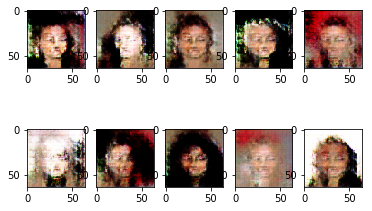

epoch: 0 D_loss: 1.0610413493271647, G_loss: 1.5133478007008951


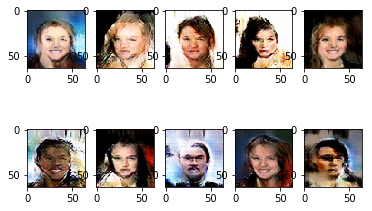

epoch: 1 D_loss: 1.0428994748126397, G_loss: 1.3729919721475514


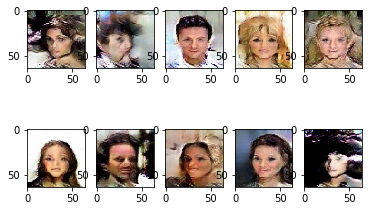

epoch: 2 D_loss: 1.0770091255355076, G_loss: 1.2476740707557914


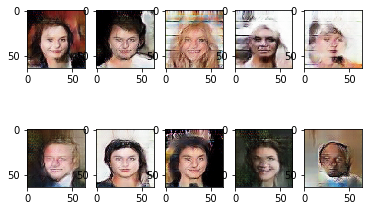

epoch: 3 D_loss: 0.8822709303031158, G_loss: 1.4742708911931945


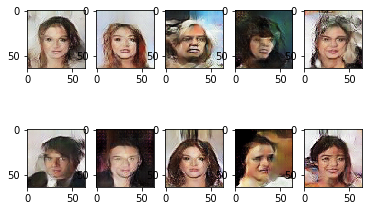

epoch: 4 D_loss: 0.6514162879972085, G_loss: 1.9103359477682855


In [8]:
## running session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    for e in range(epoch):
        data = tf.data.TFRecordDataset(path).map(parser).batch(batch_size).make_one_shot_iterator()
        batch_num = int(202600/batch_size)
        D_loss_total = 0
        G_loss_total = 0
        for batch in range(batch_num-1):                       
            _, _, image = data.get_next()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
            image_decoded = tf.decode_raw(image, tf.float32)
            decoded = sess.run(image_decoded)
            x = np.reshape(decoded, (batch_size, 64, 64, 3))
            z_d = np.random.normal(size=(batch_size, 100))
            z_g = np.random.normal(size=(batch_size, 100))
                 
            _, D_loss_temp = sess.run([D_train, D_loss], feed_dict={X: x, Z: z_d})
            _, G_loss_temp = sess.run([G_train, G_loss], feed_dict={Z: z_g})
            
            D_loss_total += D_loss_temp
            G_loss_total += G_loss_temp

        D_loss_total = D_loss_total/(batch_num - 1)
        G_loss_total = G_loss_total/(batch_num - 1)
        
        z = np.random.normal(size=[batch_size, 100])
        samples = sess.run(G, feed_dict={Z:z})
        for i in range(10):       
            img = samples[i]
            img = img.reshape(64, 64, 3)
            img = (img*127.5 + 127.5).astype(int)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
        plt.show()
        
        print("epoch: " + str(e) + " D_loss: " + str(D_loss_total) + ", G_loss: " + str(G_loss_total))
        saver.save(sess, checkpoint_path, global_step = e)

INFO:tensorflow:Restoring parameters from model/model-4


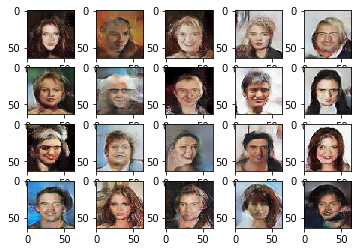

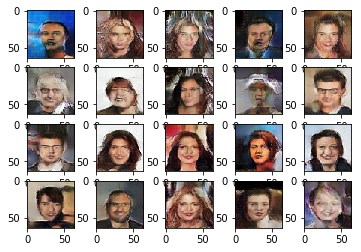

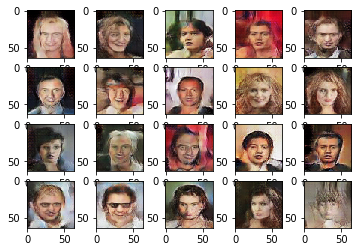

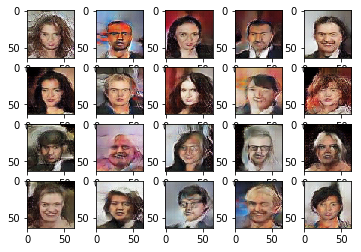

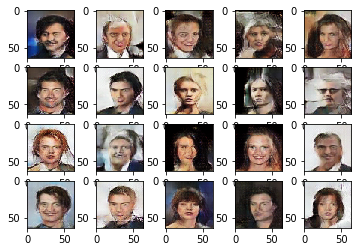

In [97]:
with tf.Session() as sess:
    saver.restore(sess, ckpt.model_checkpoint_path)
    z = np.random.normal(size=[batch_size, 100])
    samples = sess.run(G, feed_dict={Z:z})
    for i in range(5):
        for j in range(20):
            j = j%20
            img = samples[i*20 + j]
            img = img.reshape(64, 64, 3)
            img = (img*127.5 + 127.5).astype(int)
            plt.subplot(4, 5, j + 1)
            plt.imshow(img)
        plt.show()

INFO:tensorflow:Restoring parameters from model/model-4


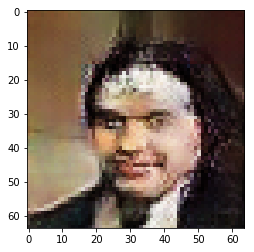

In [100]:
left_woman = (z[67] +z[58] + z[84])/3
front_woman = (z[37] + z[14] + z[60])/3
front_man = z[64]

left_man = left_woman - front_woman + front_man
z = np.random.normal(size=[batch_size, 100])
z[0] = left_man

with tf.Session() as sess:
    saver.restore(sess, ckpt.model_checkpoint_path)
    samples = sess.run(G, feed_dict={Z:z})
    img = samples[0]
    img = img.reshape(64, 64, 3)
    img = (img*127.5 + 127.5).astype(int)
    plt.imshow(img)
    plt.show()
    